## 세팅

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

## train 데이터 로드 및 병합과 컬럼정리

In [41]:
act_df = pd.read_csv(r'01.데이터\1.Training\원천데이터\1.걸음걸이\train_activity.csv')
sleep_df = pd.read_csv(r'01.데이터\1.Training\원천데이터\2.수면\train_sleep.csv')
lab_df = pd.read_csv(r"01.데이터\1.Training\라벨링데이터\1.걸음걸이\training_label.csv")

In [92]:
lab_df['DIAG_NM'].value_counts()

DIAG_NM
CN     85
MCI    47
Dem     9
Name: count, dtype: int64

In [42]:
merged_df = pd.merge(act_df, lab_df, left_on='EMAIL', right_on='SAMPLE_EMAIL', how='left')
merged_df = pd.merge(merged_df, sleep_df, left_index=True, right_index=True, how='left')

In [43]:
merged_df.rename(columns={'EMAIL_x': 'EMAIL'},inplace=True)
cols_to_drop = [c for c in merged_df.columns if c.endswith(('_x', '_y', '_list', '_5min','_1min', 'utf8)', '_start','_end'))]
merged_df.drop(columns=cols_to_drop, inplace=True)

In [44]:
drop_cols = ['sleep_temperature_delta','SAMPLE_EMAIL']
merged_df.drop(columns=drop_cols, inplace=True)

## val 데이터 로드 및 병합과 컬럼정리

In [45]:
val_act = pd.read_csv(r'01.데이터\2.Validation\원천데이터\1.걸음걸이\val_activity.csv')
val_sleep = pd.read_csv(r'01.데이터\2.Validation\원천데이터\2.수면\val_sleep.csv')
val_lab = pd.read_csv(r'01.데이터\2.Validation\라벨링데이터\1.걸음걸이\val_label.csv')

In [120]:
val_lab['DIAG_NM'].value_counts()

DIAG_NM
CN     26
MCI     4
Dem     3
Name: count, dtype: int64

In [46]:
merged_val = pd.merge(val_act, val_lab, left_on='EMAIL', right_on='SAMPLE_EMAIL', how='left')
merged_val = pd.merge(merged_val, val_sleep, left_index=True, right_index=True, how='left')

In [47]:
merged_val.rename(columns={'EMAIL_x': 'EMAIL'},inplace=True)
cols_to_drop = [c for c in merged_val.columns if c.endswith(('_x', '_y', '_list', '_5min','_1min', 'utf8)', '_start','_end'))]
merged_val.drop(columns=cols_to_drop, inplace=True)

In [48]:
drop_cols = ['sleep_temperature_delta','SAMPLE_EMAIL']
merged_val.drop(columns=drop_cols, inplace=True)

## 모델 학습

### 함수

In [ ]:
# 평균화 데이터프레임 작성 함수
def grupe_df(train_dfs, val_dfs, days=None):
    act_df , sleep_df, lab_df = train_dfs
    val_act, val_sleep, val_lab = val_dfs

    
    all_df = pd.merge(act_df, sleep_df, left_index=True, right_index=True, how='left')
    all_val = pd.merge(val_act, val_sleep, left_index=True, right_index=True, how='left')

    # 컬럼 정리
    all_df.rename(columns={'EMAIL_x': 'EMAIL'},inplace=True)
    all_val.rename(columns={'EMAIL_x': 'EMAIL'},inplace=True)

    # 컬럼 제거
    swith_list = ('_y','_5min','_1min', 'utf8)','_end')
    cols_to_drop = [c for c in all_df.columns if c.endswith(swith_list)]
    all_df.drop(columns=cols_to_drop, inplace=True)
    all_val.drop(columns=cols_to_drop, inplace=True)

    # 수면 datetime 제거
    # sleep은 시작, 종료 시간도 재각각이고 날자가 바뀌는 경우가 많음 
    # 날짜 기준은 활동데이터에서 얻어오는것이 더 간단함
    drop_cols = ['sleep_temperature_delta', 'sleep_bedtime_start']
    all_df.drop(columns=drop_cols, inplace=True)
    all_val.drop(columns=drop_cols, inplace=True)
    
    col = 'activity_day_start'
    # 날지를 지정 안하면 모든 날자의 평균 데이터
    if days is None:
        all_group = all_df.drop(columns=col)
        all_group = all_group.groupby('EMAIL', as_index=False).mean()

        all_group_val = all_val.drop(columns=col)
        all_group_val = all_group_val.groupby('EMAIL', as_index=False).mean()

    # 최근 Days만큼 평균을 구함
    else:
        all_df[col] = pd.to_datetime(all_df[col])
        all_val[col] = pd.to_datetime(all_val[col])
        for _df, _name in ((all_df, "train"), (all_val, "val")):
            # EMAIL별 최신 날짜
            max_dt = _df.groupby('EMAIL')['activity_day_start'].transform('max')
            cutoff = max_dt - pd.to_timedelta(days - 1, unit='D')

            # 최근 days일 만큼 필터링
            mask = _df['activity_day_start'] >= cutoff
            _df_recent = _df.loc[mask].copy()

            # 날짜 컬럼은 제거
            _df_recent.drop(columns=['activity_day_start'], inplace=True, errors='ignore')

            # EMAIL 기준 평균 (비수치 컬럼은 무시)
            if _name == "train":
                all_group = _df_recent.groupby('EMAIL', as_index=False).mean(numeric_only=True)
            else:
                all_group_val = _df_recent.groupby('EMAIL', as_index=False).mean(numeric_only=True)

    # 구한 값을 라벨과 병합하여 반환
    all_group = pd.merge(all_group, lab_df, left_on='EMAIL', right_on='SAMPLE_EMAIL', how='left')
    all_group = all_group.drop('SAMPLE_EMAIL', axis=1)
    all_group_val = pd.merge(all_group_val, val_lab, left_on='EMAIL', right_on='SAMPLE_EMAIL', how='left')
    all_group_val = all_group_val.drop('SAMPLE_EMAIL', axis=1)
 
 
    return all_group, all_group_val


In [ ]:
# 모델의 설정, 학습, 평가 함수
def catboost_model_fit(x, y, iterations=1000, learning_rate=0.0005, depth=6):
    model = CatBoostClassifier(
        iterations=iterations,          # 트리 개수
        learning_rate=learning_rate,      # 학습률
        depth=depth,                 # 트리 깊이
        loss_function='MultiClass',  # 다중분류
        eval_metric='TotalF1',      # 평가 지표
        use_best_model=True,        # 최적의 단계에서의 모델 선택
        od_type='Iter',     
        od_wait=200,
        random_seed=42,
        verbose=50
    )

    # X와 Y 분리 및 학습
    target_col = 'DIAG_NM'
    id_col = 'EMAIL'

    X_train = x.drop(columns=[target_col])
    X_train = X_train.drop(columns=[id_col])
    y_train = x[target_col]

    X_val = y.drop(columns=[target_col])
    X_val = X_val.drop(columns=[id_col])
    y_val = y[target_col]

    # 학습
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        use_best_model=True
    )

    # 평가
    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    print(f"Accuracy: {acc:.4f}")

    f1 = f1_score(y_val, y_pred, average='macro')
    print(f"F1-score (macro): {f1:.4f}")
    
    # 모델과 결과를 반환
    return model, y_val, y_pred

In [123]:
def feature_importance_viwe(model):
    importances = model.get_feature_importance(type='PredictionValuesChange')
    feature_names = model.feature_names_

    fi_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # 상위 10개 시각화
    plt.figure(figsize=(8, 5))
    plt.barh(fi_df['Feature'][:10][::-1], fi_df['Importance'][:10][::-1])
    plt.xlabel('Importance')
    plt.title('CatBoost Feature Importance (Top 10)')
    plt.tight_layout()
    plt.show()

### 모델 적용

In [52]:
train_df = merged_df.drop('EMAIL', axis=1)
val_df = merged_val.drop('EMAIL', axis=1)

In [53]:
target_col = 'DIAG_NM'

X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]

In [54]:
model = CatBoostClassifier(
    iterations=1000,          # 트리 개수
    learning_rate=0.0005,      # 학습률
    depth=6,                 # 트리 깊이
    loss_function='MultiClass',  # 다중분류
    eval_metric='Accuracy',
    random_seed=42,
    verbose=50
)


In [55]:
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True
)

0:	learn: 0.6050489	test: 0.7477805	best: 0.7477805 (0)	total: 15.4ms	remaining: 15.3s
50:	learn: 0.5959815	test: 0.7893462	best: 0.7901533 (5)	total: 533ms	remaining: 9.92s
100:	learn: 0.5956723	test: 0.7893462	best: 0.7901533 (5)	total: 1.01s	remaining: 8.99s
150:	learn: 0.5957754	test: 0.7893462	best: 0.7901533 (5)	total: 1.5s	remaining: 8.44s
200:	learn: 0.5957754	test: 0.7893462	best: 0.7901533 (5)	total: 2.01s	remaining: 7.99s
250:	learn: 0.5958784	test: 0.7893462	best: 0.7901533 (5)	total: 2.49s	remaining: 7.42s
300:	learn: 0.5959815	test: 0.7893462	best: 0.7901533 (5)	total: 2.98s	remaining: 6.91s
350:	learn: 0.5960845	test: 0.7893462	best: 0.7901533 (5)	total: 3.46s	remaining: 6.4s
400:	learn: 0.5960845	test: 0.7893462	best: 0.7901533 (5)	total: 3.96s	remaining: 5.91s
450:	learn: 0.5964967	test: 0.7893462	best: 0.7901533 (5)	total: 4.46s	remaining: 5.43s
500:	learn: 0.5967027	test: 0.7893462	best: 0.7901533 (5)	total: 4.97s	remaining: 4.95s
550:	learn: 0.5967027	test: 0.789346

#### 예측 평가
*   데이터 셋을 받은 AI_Hub는 정상/진단 으로 분류하였기 때문에 평가지표가 accuracy와 ROC AUC지만
*   다중 분류를 하기 때문에 F1-score를 사용해야함

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)

acc = accuracy_score(y_val, y_pred)
print(f"✅ Accuracy: {acc:.4f}")

classes = model.classes_  # ['CN', 'MCI', 'Dem']
y_val_bin = label_binarize(y_val, classes=classes)

auc = roc_auc_score(y_val_bin, y_pred_proba, multi_class='ovr')
print(f"✅ AUC-ROC (OvR): {auc:.4f}")

✅ Accuracy: 0.7902
✅ AUC-ROC (OvR): 0.6320


100.0


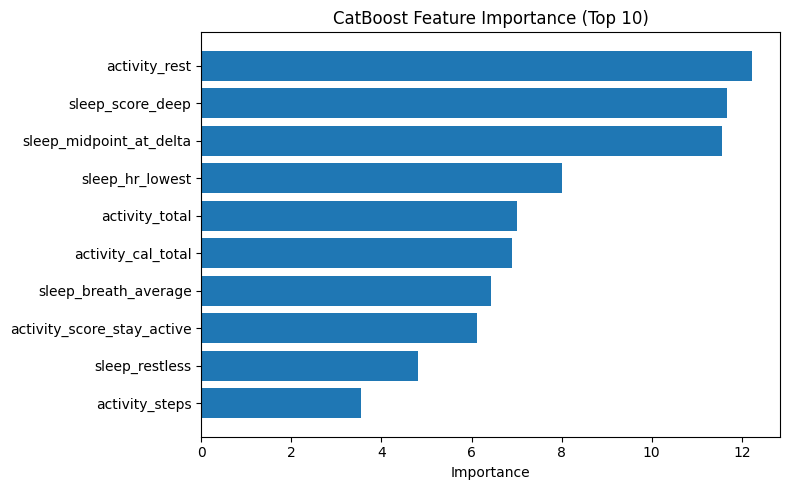

In [57]:
feature_importance_viwe(model)

0:	learn: 0.5256421	test: 0.6881033	best: 0.6881033 (0)	total: 14.4ms	remaining: 14.4s
50:	learn: 0.4454386	test: 0.6964192	best: 0.6990794 (5)	total: 524ms	remaining: 9.76s
100:	learn: 0.4447348	test: 0.6964192	best: 0.6990794 (5)	total: 1.03s	remaining: 9.21s
150:	learn: 0.4449696	test: 0.6964192	best: 0.6990794 (5)	total: 1.53s	remaining: 8.61s
200:	learn: 0.4449696	test: 0.6964192	best: 0.6990794 (5)	total: 2.04s	remaining: 8.12s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.6990794417
bestIteration = 5

Shrink model to first 6 iterations.
Accuracy: 0.7902
F1-score (macro): 0.3034
100.0


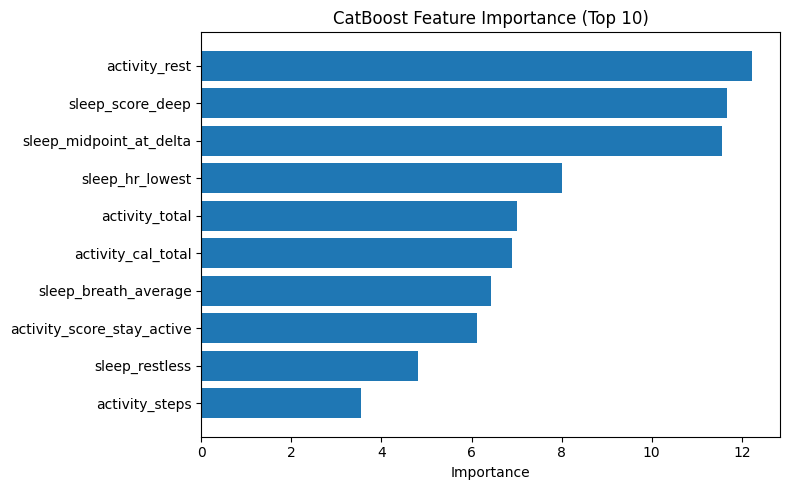

In [58]:
model, X_val, y_val = catboost_model_fit(merged_df, merged_val)

feature_importance_viwe(model)

### 그룹화 모델링

*   시계열 데이터를 직접 넣으니 과적합이 생김 -> 전채 또는 평균으로 하나로 바꾸기 or 탠서로 바꾸어 딥러닝
*   딥러닝은 성능이 안되니 데이터를 전체 평균, 마지막 7일 평균으로 만들어 학습 진행

In [59]:
all_group, all_group_val = grupe_df([act_df, sleep_df, lab_df], [val_act, val_sleep, val_lab])

0:	learn: 0.7211343	test: 0.5494949	best: 0.5494949 (0)	total: 11.9ms	remaining: 11.9s
50:	learn: 0.5278232	test: 0.6944016	best: 0.7380952 (6)	total: 336ms	remaining: 6.25s
100:	learn: 0.5670719	test: 0.6944016	best: 0.7380952 (6)	total: 643ms	remaining: 5.72s
150:	learn: 0.5670719	test: 0.6944016	best: 0.7380952 (6)	total: 968ms	remaining: 5.44s
200:	learn: 0.5278232	test: 0.6944016	best: 0.7380952 (6)	total: 1.28s	remaining: 5.07s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7380952381
bestIteration = 6

Shrink model to first 7 iterations.
Accuracy: 0.7879
F1-score (macro): 0.3929
100.0


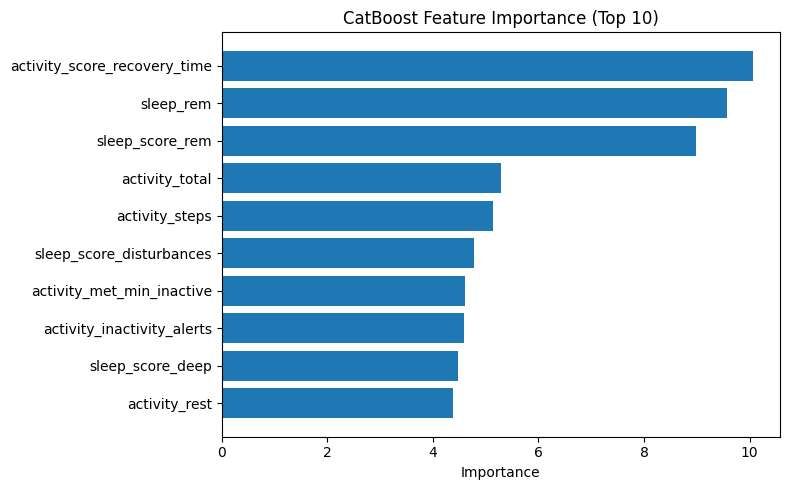

In [ ]:
model, y_val, y_pred = catboost_model_fit(all_group, all_group_val)

feature_importance_viwe(model)

In [61]:
days_group, days_group_val = grupe_df([act_df, sleep_df, lab_df], [val_act, val_sleep, val_lab], days=7)

0:	learn: 0.6554757	test: 0.5987879	best: 0.5987879 (0)	total: 8.19ms	remaining: 8.19s
50:	learn: 0.5670719	test: 0.6944016	best: 0.7380952 (8)	total: 307ms	remaining: 5.7s
100:	learn: 0.6144823	test: 0.6944016	best: 0.7380952 (8)	total: 585ms	remaining: 5.21s
150:	learn: 0.6255819	test: 0.6944016	best: 0.7380952 (8)	total: 877ms	remaining: 4.93s
200:	learn: 0.6144823	test: 0.6944016	best: 0.7380952 (8)	total: 1.16s	remaining: 4.6s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7380952381
bestIteration = 8

Shrink model to first 9 iterations.
Accuracy: 0.7879
F1-score (macro): 0.3929
99.99999999999997


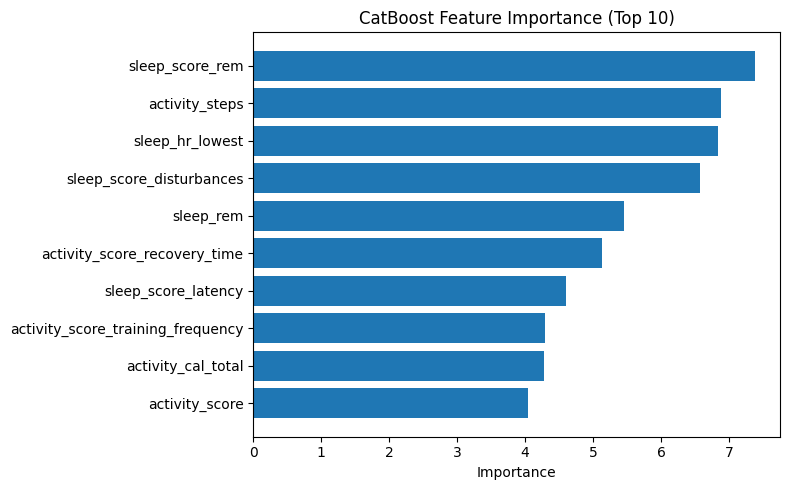

In [ ]:
model, y_val, y_pred = catboost_model_fit(days_group, days_group_val)

feature_importance_viwe(model)

#### mmse병합

In [63]:
mmse_train = pd.read_csv(r'01.데이터\1.Training\원천데이터\3.인지기능\train_mmse.csv')
mmse_val = pd.read_csv(r'01.데이터\2.Validation\원천데이터\3.인지기능\val_mmse.csv')

In [64]:
mmse_cols = [c for c in mmse_train.columns if c.startswith('Q')]
mmse_cols = mmse_cols + ['TOTAL'] + ['SAMPLE_EMAIL']

mmse_set_train = mmse_train[mmse_cols]
mmse_set_val = mmse_val[mmse_cols]

In [65]:
train_mmse_df = merged_df.merge(mmse_set_train, left_on='EMAIL',right_on='SAMPLE_EMAIL', how='left')
val_mmse_df = merged_val.merge(mmse_set_val, left_on='EMAIL',right_on='SAMPLE_EMAIL', how='left')

train_mmse_df.drop('SAMPLE_EMAIL', axis=1, inplace=True)
val_mmse_df.drop('SAMPLE_EMAIL', axis=1, inplace=True)

In [ ]:
model, y_val, y_pred = catboost_model_fit(train_mmse_df, val_mmse_df, depth=6)

0:	learn: 0.7691333	test: 0.7546281	best: 0.7546281 (0)	total: 13.9ms	remaining: 13.9s
50:	learn: 0.8463501	test: 0.7894406	best: 0.8433632 (1)	total: 554ms	remaining: 10.3s
100:	learn: 0.8393838	test: 0.7961061	best: 0.8433632 (1)	total: 1.08s	remaining: 9.6s
150:	learn: 0.8426634	test: 0.8003719	best: 0.8433632 (1)	total: 1.59s	remaining: 8.94s
200:	learn: 0.8440376	test: 0.7899740	best: 0.8433632 (1)	total: 2.11s	remaining: 8.39s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8433632383
bestIteration = 1

Shrink model to first 2 iterations.
Accuracy: 0.8761
F1-score (macro): 0.7108


In [ ]:
model, y_val, y_pred = catboost_model_fit(train_mmse_df, val_mmse_df, depth=7)

0:	learn: 0.7854813	test: 0.7725979	best: 0.7725979 (0)	total: 20ms	remaining: 20s
50:	learn: 0.8478785	test: 0.7768800	best: 0.8411892 (2)	total: 934ms	remaining: 17.4s
100:	learn: 0.8508541	test: 0.7782193	best: 0.8411892 (2)	total: 1.83s	remaining: 16.3s
150:	learn: 0.8520651	test: 0.7790225	best: 0.8411892 (2)	total: 2.72s	remaining: 15.3s
200:	learn: 0.8579415	test: 0.7774158	best: 0.8411892 (2)	total: 3.59s	remaining: 14.3s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8411891855
bestIteration = 2

Shrink model to first 3 iterations.
Accuracy: 0.8729
F1-score (macro): 0.7101


In [ ]:
model, y_val, y_pred = catboost_model_fit(train_mmse_df, val_mmse_df, depth=8)

0:	learn: 0.8077112	test: 0.7189963	best: 0.7189963 (0)	total: 50.4ms	remaining: 50.3s
50:	learn: 0.8870073	test: 0.7774158	best: 0.8159076 (2)	total: 2.39s	remaining: 44.5s
100:	learn: 0.8839295	test: 0.7889071	best: 0.8159076 (2)	total: 4.75s	remaining: 42.2s
150:	learn: 0.8759585	test: 0.7873063	best: 0.8159076 (2)	total: 7.37s	remaining: 41.4s
200:	learn: 0.8770131	test: 0.7838355	best: 0.8159076 (2)	total: 9.79s	remaining: 38.9s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8159075969
bestIteration = 2

Shrink model to first 3 iterations.
Accuracy: 0.8341
F1-score (macro): 0.6666


##### 규제 강화 모델

In [ ]:
def catboost_model_fit_reg(x, y, iterations=1000, learning_rate=0.0005, depth=6):
    model = CatBoostClassifier(
        iterations=iterations,          # 트리 개수
        learning_rate=learning_rate,      # 학습률
        depth=depth,                 # 트리 깊이
        loss_function='MultiClass',  # 다중분류
        eval_metric='TotalF1',
        use_best_model=True,
        l2_leaf_reg=8,
        rsm=0.7,
        bagging_temperature=1,
        class_weights=[1.0, 1.8, 9.4],
        od_type='Iter', 
        od_wait=200,
        random_seed=42,
        verbose=50
    )

    target_col = 'DIAG_NM'
    id_col = 'EMAIL'

    X_train = x.drop(columns=[target_col])
    X_train = X_train.drop(columns=[id_col])
    y_train = x[target_col]

    X_val = y.drop(columns=[target_col])
    X_val = X_val.drop(columns=[id_col])
    y_val = y[target_col]

    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        use_best_model=True
    )

    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    print(f"Accuracy: {acc:.4f}")

    f1 = f1_score(y_val, y_pred, average='macro')
    print(f"F1-score (macro): {f1:.4f}")
    return model, y_val, y_pred

In [ ]:
model, y_val, y_pred = catboost_model_fit_reg(train_mmse_df, val_mmse_df, depth=5)

0:	learn: 0.7429238	test: 0.3954301	best: 0.3954301 (0)	total: 9.93ms	remaining: 9.92s
50:	learn: 0.7421837	test: 0.3937117	best: 0.3954301 (0)	total: 430ms	remaining: 8.01s
100:	learn: 0.7421837	test: 0.3937117	best: 0.3954301 (0)	total: 847ms	remaining: 7.54s
150:	learn: 0.7421837	test: 0.3937117	best: 0.3954301 (0)	total: 1.26s	remaining: 7.07s
200:	learn: 0.7421837	test: 0.3937117	best: 0.3954301 (0)	total: 1.68s	remaining: 6.69s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3954300982
bestIteration = 0

Shrink model to first 1 iterations.
Accuracy: 0.1259
F1-score (macro): 0.0752


### 각 사람 별 데이터 전체, 최근 7일

In [ ]:
all_group_mmse = all_group.merge(mmse_set_train, left_on='EMAIL',right_on='SAMPLE_EMAIL', how='left')
all_group_val_mmse = all_group_val.merge(mmse_set_val, left_on='EMAIL',right_on='SAMPLE_EMAIL', how='left')

all_group_mmse.drop('SAMPLE_EMAIL', axis=1, inplace=True)
all_group_val_mmse.drop('SAMPLE_EMAIL', axis=1, inplace=True)

model, y_val, y_pred = catboost_model_fit(all_group_mmse, all_group_val_mmse ,depth=8)

0:	learn: 0.7681416	test: 0.5580808	best: 0.5580808 (0)	total: 36.5ms	remaining: 36.5s
50:	learn: 0.8662245	test: 0.7642212	best: 0.7770563 (14)	total: 1.75s	remaining: 32.6s
100:	learn: 0.8740974	test: 0.7770563	best: 0.7770563 (14)	total: 3.58s	remaining: 31.9s
150:	learn: 0.8740974	test: 0.7642212	best: 0.7770563 (14)	total: 5.33s	remaining: 30s
200:	learn: 0.8740974	test: 0.7187666	best: 0.7770563 (14)	total: 7.08s	remaining: 28.1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7770562771
bestIteration = 14

Shrink model to first 15 iterations.
Accuracy: 0.8182
F1-score (macro): 0.4762


In [ ]:
days_group_mmse = days_group.merge(mmse_set_train, left_on='EMAIL',right_on='SAMPLE_EMAIL', how='left')
days_group_val_mmse = days_group_val.merge(mmse_set_train, left_on='EMAIL',right_on='SAMPLE_EMAIL', how='left')

days_group_mmse.drop('SAMPLE_EMAIL', axis=1, inplace=True)
days_group_val_mmse.drop('SAMPLE_EMAIL', axis=1, inplace=True)

model, y_val, y_pred = catboost_model_fit(days_group_mmse, days_group_val_mmse, depth=8)

0:	learn: 0.7426213	test: 0.5550761	best: 0.5550761 (0)	total: 32.4ms	remaining: 32.4s
50:	learn: 0.8818792	test: 0.4306497	best: 0.5550761 (0)	total: 1.58s	remaining: 29.4s
100:	learn: 0.8896447	test: 0.6095807	best: 0.6095807 (83)	total: 3.12s	remaining: 27.8s
150:	learn: 0.8896447	test: 0.6581028	best: 0.6581028 (122)	total: 4.79s	remaining: 26.9s
200:	learn: 0.8818310	test: 0.6315710	best: 0.6742505 (165)	total: 6.31s	remaining: 25.1s
250:	learn: 0.8740974	test: 0.5603000	best: 0.6742505 (165)	total: 7.96s	remaining: 23.8s
300:	learn: 0.8896447	test: 0.5992326	best: 0.6742505 (165)	total: 9.68s	remaining: 22.5s
350:	learn: 0.8818792	test: 0.5849673	best: 0.6742505 (165)	total: 11.4s	remaining: 21.1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.6742505267
bestIteration = 165

Shrink model to first 166 iterations.
Accuracy: 0.6061
F1-score (macro): 0.5875


## 비교 모델

In [118]:
from typing import Tuple
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


# 공통 전처리 & 평가 헬퍼
def _prep_xy(df_train: pd.DataFrame, df_val: pd.DataFrame,
             target_col: str = "DIAG_NM", id_col: str = "EMAIL",
             encode_label: bool = False):
    X_train = df_train.drop(columns=[target_col, id_col], errors="ignore")
    y_train = df_train[target_col].copy()
    X_val   = df_val.drop(columns=[target_col, id_col], errors="ignore")
    y_val   = df_val[target_col].copy()

    le = None
    if encode_label:
        le = LabelEncoder()
        y_train = le.fit_transform(y_train)
        y_val   = le.transform(y_val)

    return X_train, y_train, X_val, y_val, le


def _evaluate_and_print(y_true, y_pred, model_name="Model", average="macro"):
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average=average)
    print(f"[{model_name}] Accuracy: {acc:.4f}")
    print(f"[{model_name}] F1-score ({average}): {f1:.4f}")


# 1) RandomForest
def rf_model_fit(x: pd.DataFrame, y: pd.DataFrame,
                 n_estimators: int = 400, max_depth: int = None,
                 random_state: int = 42) -> Tuple[RandomForestClassifier, pd.DataFrame, pd.Series]:
    # RF는 문자열 라벨도 처리 가능하나, 일관성 위해 인코딩하지 않아도 OK
    X_train, y_train, X_val, y_val, _ = _prep_xy(x, y, encode_label=False)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        n_jobs=-1,
        class_weight="balanced",   # 불균형 대응
        random_state=random_state
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    _evaluate_and_print(y_val, y_pred, model_name="RandomForest", average="macro")
    return model, X_val, y_val


# 2) LightGBM (다중분류는 보통 라벨 인코딩 권장)
def lgbm_model_fit(x: pd.DataFrame, y: pd.DataFrame,
                   learning_rate: float = 0.05,
                   num_leaves: int = 31,
                   n_estimators: int = 2000,
                   early_stopping_rounds: int = 100,
                   random_state: int = 42) -> Tuple[LGBMClassifier, pd.DataFrame, np.ndarray]:
    X_train, y_train_enc, X_val, y_val_enc, le = _prep_xy(x, y, encode_label=True)
    num_class = len(np.unique(y_train_enc))

    model = LGBMClassifier(
        objective="multiclass",
        num_class=num_class,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        n_estimators=n_estimators,
        class_weight="balanced",
        random_state=random_state,
        n_jobs=-1
    )

    model.fit(
        X_train, y_train_enc,
        eval_set=[(X_val, y_val_enc)],
        eval_metric="multi_logloss",
        callbacks=[lgb.early_stopping(stopping_rounds=early_stopping_rounds)]
    )

    # 조기 종료
    model.set_params(**{"n_estimators": model.best_iteration_ if model.best_iteration_ else n_estimators})

    y_pred_enc = model.predict(X_val)
    _evaluate_and_print(y_val_enc, y_pred_enc, model_name="LightGBM", average="macro")
    # 필요 시 원라벨: le.inverse_transform(y_pred_enc)
    return model, X_val, y_val_enc


# 3) XGBoost (다중분류는 라벨 인코딩 필수)
def xgb_model_fit(x: pd.DataFrame, y: pd.DataFrame,
                  learning_rate: float = 0.05,
                  max_depth: int = 6,
                  n_estimators: int = 2000,
                  subsample: float = 0.9,
                  colsample_bytree: float = 0.9,
                  early_stopping_rounds: int = 100,
                  random_state: int = 42) -> Tuple[XGBClassifier, pd.DataFrame, np.ndarray]:
    X_train, y_train_enc, X_val, y_val_enc, le = _prep_xy(x, y, encode_label=True)
    num_class = len(np.unique(y_train_enc))

    model = XGBClassifier(
        objective="multi:softprob",
        num_class=num_class,
        learning_rate=learning_rate,
        max_depth=max_depth,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_lambda=1.0,
        n_jobs=-1,
        random_state=random_state,
        early_stopping_rounds=early_stopping_rounds,
        tree_method="hist"  # GPU면 'gpu_hist'로 변경 가능
    )

    model.fit(
        X_train, y_train_enc,
        eval_set=[(X_val, y_val_enc)],
        verbose=False
    )

    y_pred_enc = model.predict(X_val)
    _evaluate_and_print(y_val_enc, y_pred_enc, model_name="XGBoost", average="macro")
    return model, X_val, y_val_enc


In [70]:
_, _, _ = rf_model_fit(train_mmse_df, val_mmse_df)

[RandomForest] Accuracy: 0.8083
[RandomForest] F1-score (macro): 0.6718


In [116]:
_, _, _ = lgbm_model_fit(train_mmse_df, val_mmse_df)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7276
[LightGBM] [Info] Number of data points in the train set: 9705, number of used features: 76
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.706716
[LightGBM] Accuracy: 0.7341
[LightGBM] F1-score (macro): 0.6594


In [119]:
_, _, _ = xgb_model_fit(train_mmse_df, val_mmse_df)

[XGBoost] Accuracy: 0.7385
[XGBoost] F1-score (macro): 0.6606
